In [35]:
import torch
import torchvision 
import numpy as np
import matplotlib.pyplot as plt
import einops
from tqdm import tqdm

In [2]:
def imshow(img, figsize):
    if len(img.shape) == 4:
        img = img[0]
    
    if img.shape[0] == 3:
        img = einops.rearrange(img, "c h w -> h w c", c = 3)
    
    plt.figure(figsize=figsize)
    plt.imshow(img)

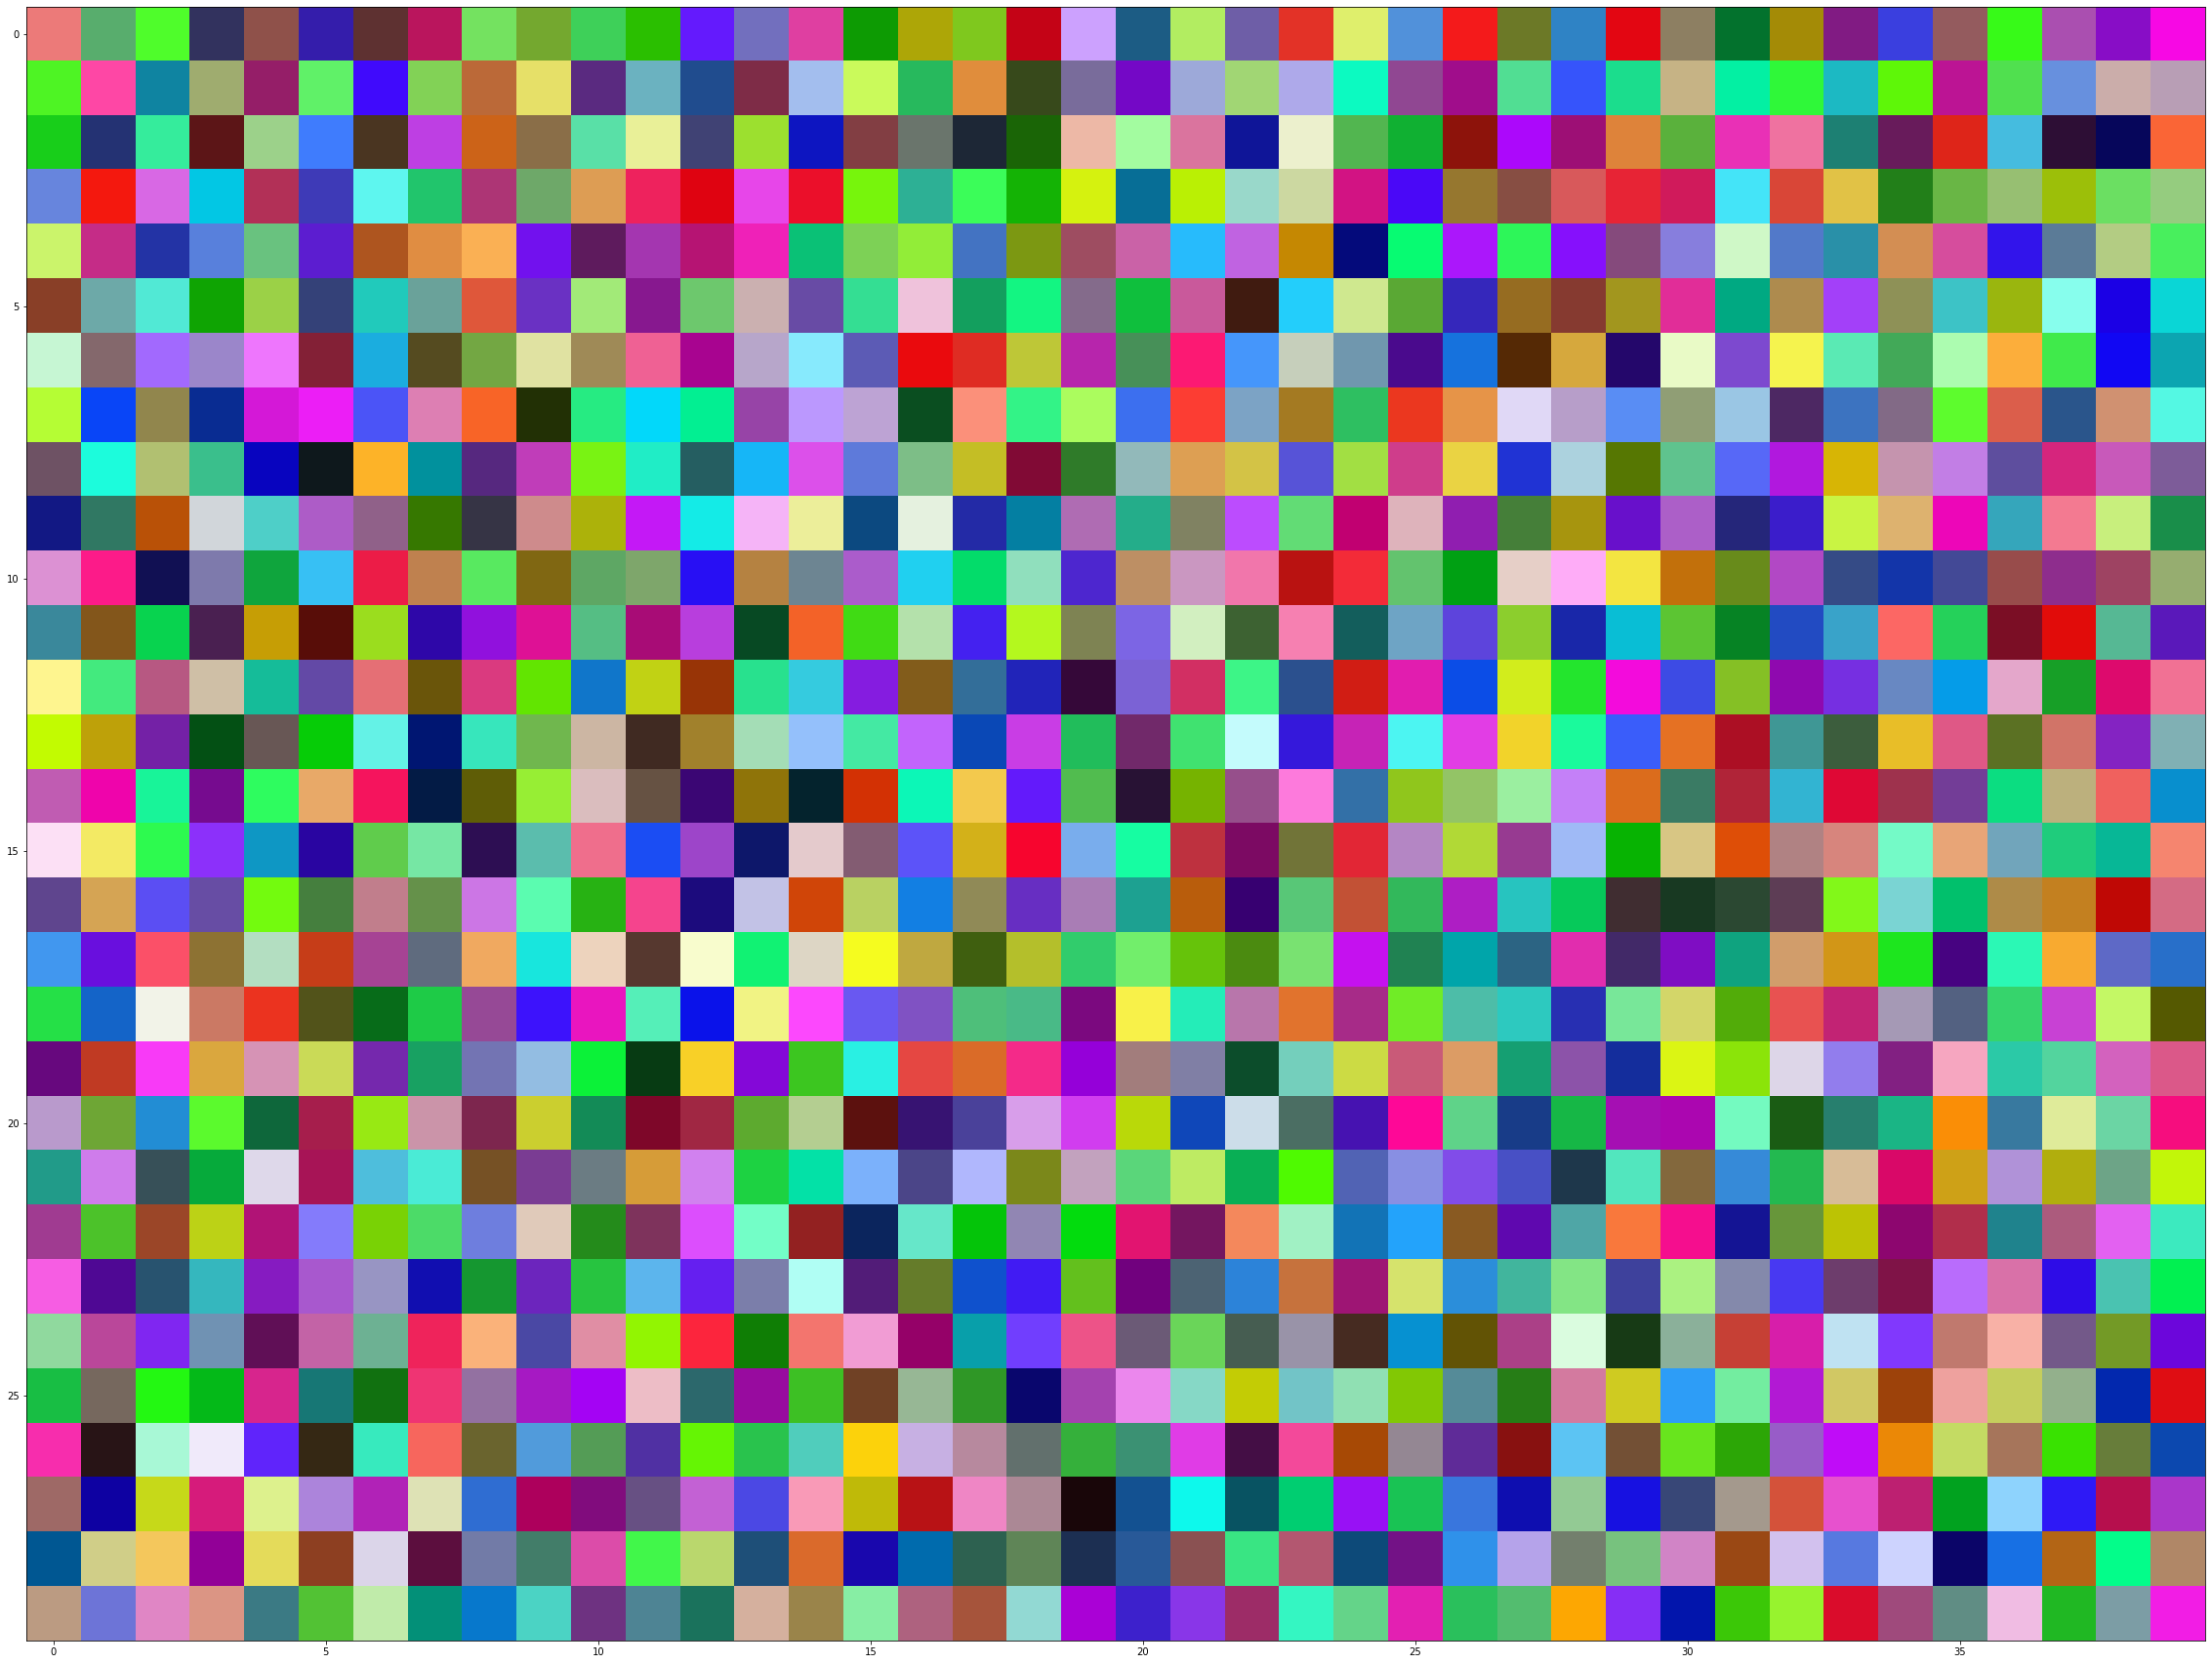

In [3]:
arr = np.random.rand(30,40,3)

imshow(arr, (40, 50))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
class OptimisedImageClipped(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.random_ass_name = torch.nn.parameter.Parameter(torch.rand(1, 3, 244, 244))

    def forward(self):
        return torch.clamp(self.random_ass_name, min=0, max=1)


In [33]:
def train(model, img, logit=50, lr=0.05, epochs=10):
    optimizer = torch.optim.Adam(img.parameters(), lr=lr)
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss = -model(img())[0,logit]
        loss.backward()
        optimizer.step()
    
    return img

In [63]:
model = torchvision.models.resnet34(pretrained=True)
model.eval()

def visualize(train=train, img=OptimisedImageClipped(), epochs=10, lr=0.05, figsize=(5,5)):
    imshow(img().detach(), figsize)
    try:
        train(model, img, epochs=epochs, lr=lr)
    except KeyboardInterrupt:
        imshow(img().detach(), figsize)
    imshow(img().detach(), figsize)


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


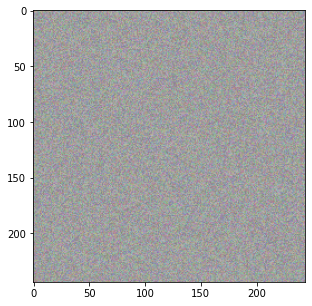

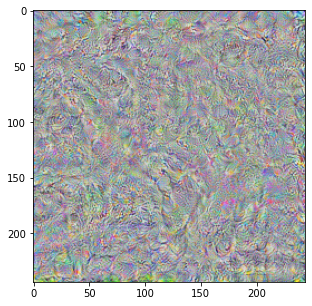

In [41]:
class OptimisedImageSigmoid(OptimisedImageClipped):
    def forward(self):
        return torch.sigmoid(self.random_ass_name)
    
visualize(OptimisedImageSigmoid(), epochs=100)

In [47]:
def train_with_transform(model, img, logit=50, lr=0.05, epochs=10):
    optimizer = torch.optim.Adam(img.parameters(), lr=lr)
    transforms = torch.nn.Sequential(
        torchvision.transforms.RandomAffine(5, translate=(0.01, 0.01)),
        torchvision.transforms.ColorJitter(),
    )
    scripted_transforms = torch.jit.script(transforms)
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss = -model(scripted_transforms(img()))[0,logit]
        loss.backward()
        optimizer.step()
    return img

100%|██████████| 1000/1000 [09:06<00:00,  1.83it/s]


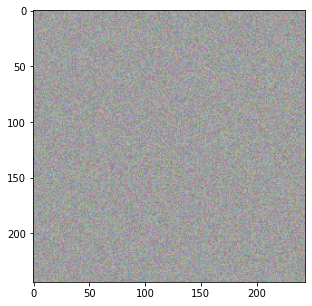

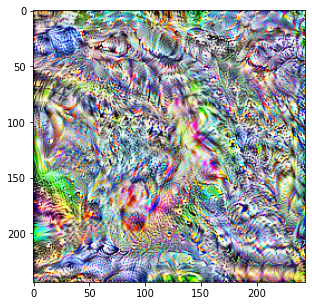

In [50]:
visualize(train=train_with_transform, img=OptimisedImageSigmoid(), epochs=1000)

In [92]:
class OptimizedImageFourier(torch.nn.Module):
    def __init__(self, scale=50) -> None:
        super().__init__()
        self.scale = scale
        self.freq_params = torch.nn.parameter.Parameter(torch.randn(1, 3, 244, 113, 2))

    def forward(self):
        return torch.sigmoid(self.scale*torch.fft.irfft2(torch.view_as_complex(self.freq_params)))


 20%|█▉        | 1986/10000 [55:10<3:42:39,  1.67s/it]   


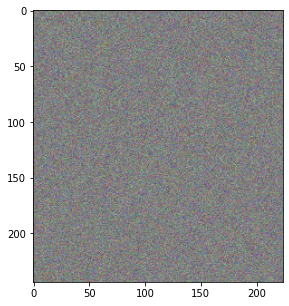

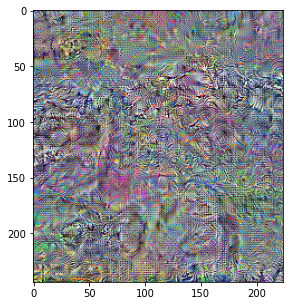

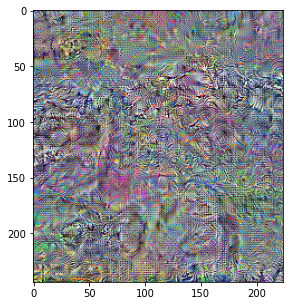

In [109]:
visualize(train=train, img=OptimizedImageFourier(), lr=0.1, epochs=1_000)

In [116]:
class OptimizedImageFourierNormalised(torch.nn.Module):
    def __init__(self, scale=50) -> None:
        super().__init__()
        fx = torch.fft.fftfreq(113)
        fy = torch.fft.fftfreq(244)

        self.register_buffer = torch.sqrt(fx ** 2) + torch.sqrt(fy ** 2).unsqueeze(1)
        self.register_buffer[0][0] = 1 / 244.0
        
        self.freq_params = torch.nn.parameter.Parameter(scale * torch.randn(1, 3, 244, 113, 2))

    def forward(self):
        return torch.sigmoid(torch.fft.irfft2(torch.view_as_complex(self.freq_params) / self.register_buffer))


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


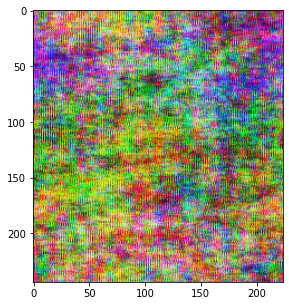

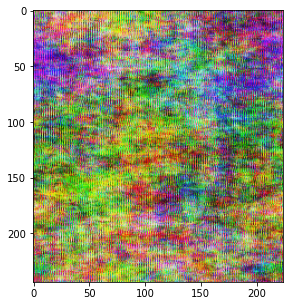

In [118]:
visualize(train=train, img=OptimizedImageFourierNormalised(), lr=0.1, epochs=100)